# Introduction to Deep Learning, HW 4


**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Yifan Li

## Problem 2: Interpolation between images using GAN (24 points)

**Trained GANs can generate images from a simple random distribution (e.g., Gaussian or uniform).
We can in principle “animate” the transition of one image into another by interpolating between
them using linear interpolation in the space of the simple random distribution, rather than image
space.**

### **(a) Train a GAN on MNIST using class code as starting point.**

**Generative Adversarial Networks**, introduced by Ian Goodfellow in 2014, are neural nets we can train to* produce* new images (or other kinds of data) that look as though they came from our true data distribution. In this notebook, we'll implement a small GAN for generating images that look as though they come from the MNIST dataset.

The key insight behind the GAN is to pit two neural networks against each other. On the one hand is the **Generator**, a neural network that takes random noise as input and produces an image as output. On the other hand is the **Discriminator**, which takes in an image and classifies it as real (from MNIST) or fake (from our Generator). During training, we alternate between training the Generator to fool the Discriminator, and training the Discriminator to call the Generator's bluff.

Implementing a GAN in Tensorflow will give you practice turning more involved models into working code, and is also a good showcase for Tensorflow's **variable scope** feature.

#### *Imports and Loading the data*

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### *Utility functions*

The `variables_from_scope` function lists all variables created within a given scope. This will be useful later, when we want to update all "discriminator" variables, but no "generator" variables, or vice versa.

In [0]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

 We'll also provide a simple function for displaying a few 28-pixel images. This will help us understand the progress of our GAN as it trains; we'll use it to visualize the generated 'fake digit' images.

In [0]:
def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

#### *Hyperparameters*

In [0]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 25000

#### *Generator*

A GAN is made up of two smaller networks: a generator and a discriminator. The generator is responsible for sampling images from a distribution that we hope will get closer and closer, as we train, to the real data distribution.

Neural networks are deterministic, so in order to sample a new image from the generator, we first create some random noise `z` (in our case, `z` will be a 32-dimensional uniform random variable) and then feed that noise to the network. You can think of `z` as being a latent, low-dimensional representation of some image `G(z)`, though in a vanilla GAN, it is usually difficult to interpret `z`'s components in a meaningful way.

Our generator is a dead-simple multi-layer perceptron (feed-forward network), with 128 hidden units. We use sigmoid activation at the end, to make sure our output pixels are each in the range `[0, 1]` (with 0 as black, and 1 as white).

In [0]:
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

#### *Discriminator*

Although it isn't necesssary, it makes some sense for our discriminator to mirror the generator's architecture, as we do here. The discriminator takes in an image (perhaps a real one from the MNIST dataset, perhaps a fake one from our generator), and attempts to classify it as real (1) or fake (0). Our architecture is again a simple MLP, taking 784 pixels down to 128 hidden units, and finally down to a probability.

Note that we will *reuse* this function, which builds the discriminator graph, twice. We give each layer a name, `D1` and `D2` respectively, so that when this function is called multiple times, tf.layers will be able to reuse the same variables for each "copy" of the graph that is created.

In [0]:
# Discriminator
def discriminator(images):
    hidden_layer = tf.layers.dense(images, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

#### *Building the graph*

Given a generator and discriminator, we can now set up the GAN's computational graph. 

We use Tensorflow's variable scope feature for two purposes. 

1.   First, it helps separate the variables used by the generator and by the discriminator; this is important, because when training, we want to alternate between updating each set of variables according to a different objective. 

2.   Second, scoping helps us reuse the same set of discriminator weights both for the operations we perform on *real* images and for those performed on *fake* images. To achieve this, after calling `discriminator` for the first time (and creating these weight variables), we tell our current scope to `reuse_variables()`, meaning that on our next call to `discriminator`, existing variables will be reused rather than creating new ones.



In [0]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables() 
    d_on_real = discriminator(real_X)

# Loss
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

#### *Training a GAN*

1.   Each iteration, we first train the generator, then (separately) the discriminator.

2.   Each iteration, we need to feed in a batch of images. But we also need a batch of noise samples. For this, we use Numpy's `np.random.uniform` function.

3.   Every 1000 iterations, we log some data to the console and visualize a few samples from our generator.



Iter [       0] Time [0.0791] d_loss [1.6421]


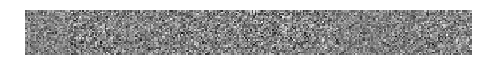

Iter [    1000] Time [4.5847] d_loss [0.0096]


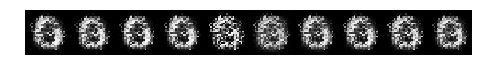

Iter [    2000] Time [9.0006] d_loss [0.0311]


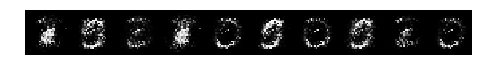

Iter [    3000] Time [13.4501] d_loss [0.1380]


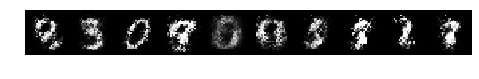

Iter [    4000] Time [17.8351] d_loss [0.1559]


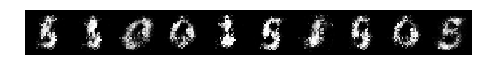

Iter [    5000] Time [22.2782] d_loss [0.3143]


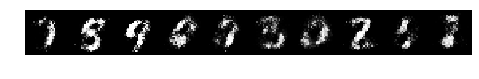

Iter [    6000] Time [26.7368] d_loss [0.1902]


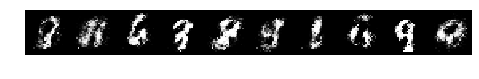

Iter [    7000] Time [31.1738] d_loss [0.3933]


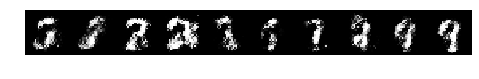

Iter [    8000] Time [35.6255] d_loss [0.4476]


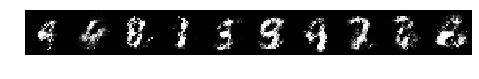

Iter [    9000] Time [40.0647] d_loss [0.2876]


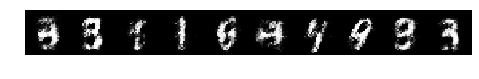

Iter [   10000] Time [44.4206] d_loss [0.5203]


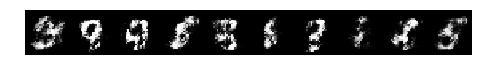

Iter [   11000] Time [48.8622] d_loss [0.4176]


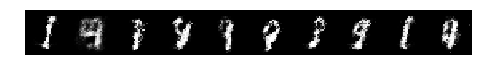

Iter [   12000] Time [53.2830] d_loss [0.6504]


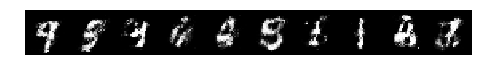

Iter [   13000] Time [57.7223] d_loss [0.4730]


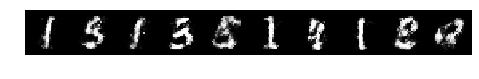

Iter [   14000] Time [62.1605] d_loss [0.5069]


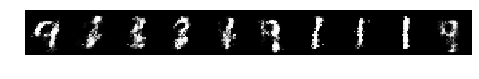

Iter [   15000] Time [66.4930] d_loss [0.7072]


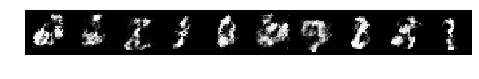

Iter [   16000] Time [70.9345] d_loss [0.9121]


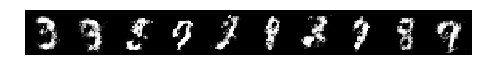

Iter [   17000] Time [75.3666] d_loss [0.6606]


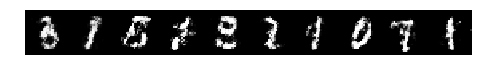

Iter [   18000] Time [79.7950] d_loss [0.8023]


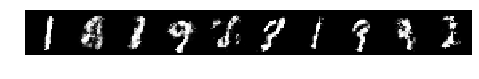

Iter [   19000] Time [84.2280] d_loss [0.8874]


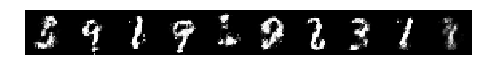

Iter [   20000] Time [88.6614] d_loss [0.4891]


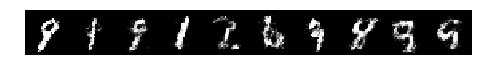

Iter [   21000] Time [93.0343] d_loss [0.6469]


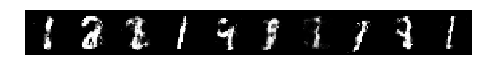

Iter [   22000] Time [97.4746] d_loss [0.5872]


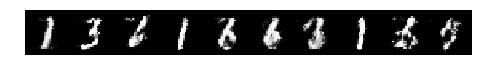

Iter [   23000] Time [101.9242] d_loss [0.8458]


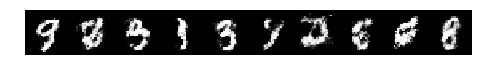

Iter [   24000] Time [106.3667] d_loss [0.5467]


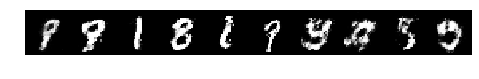

Iter [   24999] Time [110.9774] d_loss [0.8054]


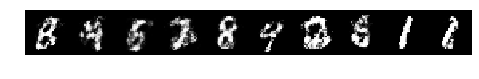

In [11]:
# Train the GAN.
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(g_step, feed_dict=next_feed_dict())
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

### (b) Generate some images, say 10, by first drawing samples, ${\epsilon}$, from the simple distribution and then feeding them through the generator.

In [0]:
epsilons = np.random.uniform(-1.0, 1.0, [10, z_dimension])
fake_data = sess.run(fake_X, feed_dict={z: epsilons})

### (c) Visualize the images and pick any two (preferably different digit labels), identify their inputs and set them to $\epsilon_{start}$ and $\epsilon_{end}$.

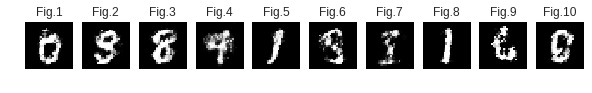

In [16]:
images = np.reshape(fake_data, [-1, 28, 28])
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray')
    plt.title("Fig.{}".format(i+1))
plt.show()

In [0]:
# Pick Fig.3 and Fig.8 from above
epsilon_start = epsilons[7] # digit 1
epsilon_end = epsilons[2] # digit 8

### (d) Generate 10 steps between $\epsilon_{start}$ and $\epsilon_{end}$ by linear interpolation.

In [0]:
epsilon_steps = []
for i in range (10):
    step = epsilon_start + i * (epsilon_end-epsilon_start) / 9
    epsilon_steps.append(step)
    # print("Step generated: ", epsilon_steps[i])

### (e) Generate 10 images using $\epsilon_{start} = \epsilon_{1}, ... , \epsilon_{10} = \epsilon_{end} $ as inputs to the generator and visualize them.

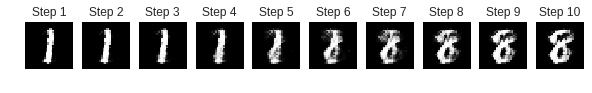

In [20]:
fake_data = sess.run(fake_X, feed_dict={z: epsilon_steps})

images = np.reshape(fake_data, [-1, 28, 28])
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(images[i], cmap='gray')
    plt.title("Step {}".format(i+1))
plt.show()

## Problem 3: Interpolating with variational autoencoders (24 points)
**We can similarly interpolate between images using Variational Autoencoders (VAE).**

### (a)	Train a variational autoencoder on MNIST using class code as starting point.
Variational Autoencoders (VAE) are a popular model that allows for unsupervised (and semi-supervised) learning. In this notebook, we'll implement a simple VAE on the MNIST dataset.

One of the primary goals of the VAE (and auto-encoders in general) is to reconstruct the original input. Why would we want to do that? At first glance, such a model seems silly: a simple identity function achieves the same thing with perfect results. However, with an autoencoder, we can learn a compresesed representation in a smaller latent space, allowing us to learn features and structure of the data. Autoencoders are composed of two arms, the **encoder** and **decoder**, which convert values from the data space to the latent space and vice versa, respectively.

Importantly, since we're simply reconstructing the original input, we do *not* necessarily need labels to do our learning, as we have in previous examples. This is significant, as labels are often far more expensive to acquire than raw data, often prohibitively so. VAEs therefore allow us to leverage abundant unlabeled data. That said, VAEs are also able to take advantage of labels when available as well, either in a completely supervised or semi-supervised setting. Altogether, autoencoders can achieve impressive results on tasks like denoising, segmentation, and even predicting future images.

#### *Imports and Data*

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
# This helper function plots the original inputs in one column and the 
# reconstructions next to them in another column.
def visualize_row(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[0].axis("off")
    ax[0].set_title("Original")
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    ax[1].axis("off")
    ax[1].set_title("Reconstructed")
    plt.show()

#### *Encoder*

The encoder deterministically transforms the data $x$ from the data space to the latent space of $z$. Since we're dealing with a *variational *autoencoder, we attempt to model the *distribution* of the latent space given the input, represented by $q(z|x)$. This isn't immediately obvious in the code implementation, but we assume a standard Gaussian prior on this distribution, and our encoder returns the mean and variance (actually log-variance) of this distribution. We use log-variance because our model returns a real number, while variances must be positive.

MNIST is a very simple dataset, so let's also keep the model simple: an MLP with 2 fully connected layers. We name the output `mu_logvar` as we will be interpretting the first half of the final 128-dimensional vector as the mean $\mu$ and the second half as the log-variance log($\sigma^2$).

In [0]:
def encoder(x):
    """Network q(z|x)
    2 FC layers
    input: flattened image
    output: 128-D vector (the first 64 elements are interpreted as the mean,
                          and the second half as the log-variance)
    """
    with slim.arg_scope([slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):
        mu_logvar = slim.fully_connected(x, 128, scope='fc1')
        mu_logvar = slim.fully_connected(mu_logvar, 128, activation_fn=None, scope='fc2')
        
    return mu_logvar

 Note that we use a couple features of TF-Slim here:
1. We use `slim.fully_connected()` to specify which layers we want to use, without having to worry about defining weight or bias variables beforehand.
2. We use `slim.arg_scope()` to specify default arguments so we can leave them out of the definitions of each of the fully connected layers. We can still override the activation_fn for the last layer though.

For this simple model, TF-Slim doesn't actually benefit us all that much, but for the sake of demonstration, we'll stick with it.

#### *Decoder*

The decoder is the generative arm of the auotencoder. Just like our encoder learned parameters of a distribution $p(z|x)$, our decoder will learn parameters of a distribution $p(x|z)$. Beceause $x$ is binary data (black and white pixels), we will use a Bernoulli distribution. Our generative neural network will learn the mean of this Bernoulli distribution for each pixel we want to generate. Another viewpoint: if our neural network outputs $\hat{x}_j$ for pixel $j$, it means we believe that the pixel will be white with that probability.

Again, since MNIST is simple, we'll use a 2 layer MLP for the decoder. Importantly, since we are focusing on reconstruction, we make sure that the final output of the decoder $\hat{x}$ is the same dimensions as our input $x$.

In [0]:
def decoder(mu_logvar):
    """Network p(x|z)"""
    # Interpret z as concatenation of mean and log variance
    mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)

    # Standard deviation must be positive
    stddev = tf.sqrt(tf.exp(logvar))

    # Draw a z from the distribution
    epsilon = tf.random_normal(tf.shape(stddev))
    z = mu + tf.multiply(stddev, epsilon)

    # Decoding arm
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):        
        x_logits = slim.fully_connected(z, 128, scope='fc1')
        x_logits = slim.fully_connected(x_logits, 784, activation_fn=None, scope='fc2')
        
        # x_hat to be generated from a Bernoulli distribution
        x_dist = tf.contrib.distributions.Bernoulli(logits=x_logits, dtype=tf.float32)
        
    return x_logits, x_dist

#### *Loss*

Like all variational inference techniques, VAEs try to match the variational posterior distribution (here a neural network) with the true posterior. However, at the end of the derivation, we can think of our model as trading off two goals:

1. Reconstruction loss: Our generator produces parameters to a Bernoulli distribution that is supposed to represent $p(x | z)$; because we assume that $z$ is the latent representation of an actual data point $x$, we can measure how well we achieve this goal by measuring the *likelihood* of $x$ according to that Bernoulli distribution. Another way of thinking of this is that we can measure how similar our reconstructed image is to our original image. The measure of similarity we use is cross-entropy: we think of our model as classifying each pixel as black or white, and we measure how good the classifier is using the classic sigmoid cross-entropy loss.

2. KL Divergence: Because this model is **variational**, we also include a KL penalty to impose a Gaussian prior on the latent space. The exact derivation of this term can be found in the original Auto-Encoding Variational Bayes paper. *Is a standard Gaussian prior a good assumption? What are the potential weaknesses of this approach?*

We use the ADAM algorithm that we've used before for optimization.

In [0]:
def optimizer(x_logits, x, mu_logvar):
    """Define loss functions (reconstruction, KL divergence) and optimizer"""
    with tf.variable_scope('optimizer') as scope:            
        # Reconstruction loss
        reconstruction = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logits), reduction_indices=[1])
 
        # KL divergence
        mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        kl_d = -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar), reduction_indices=[1])
        
        # Total loss
        loss = tf.reduce_mean(reconstruction + kl_d)
            
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
    
    return train_step

#### *Define the graph and train*
All of the functions we've written thus far are just that: functions. We still need to call them to assemble our TensorFlow computation graph. At this point, this should be becoming familiar. 

One of the small differences is the inclusion of `tf.reset_default_graph()`, added to remedy a small, unfortunate side effect of using Jupyter and TensorFlow in conjunction, but you don't have to worry about it too much to understand the model. 

In [0]:
# Reset the graph
tf.reset_default_graph()

# Define input placeholder
x = tf.placeholder(tf.float32,[None, 784], name='x')

# Define VAE graph
with tf.variable_scope('encoder'):
    mu_logvar = encoder(x)
with tf.variable_scope('decoder'):
    x_logits, x_dist = decoder(mu_logvar)
    x_hat = x_dist.sample()

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_logits, x, mu_logvar)


Iteration 0:


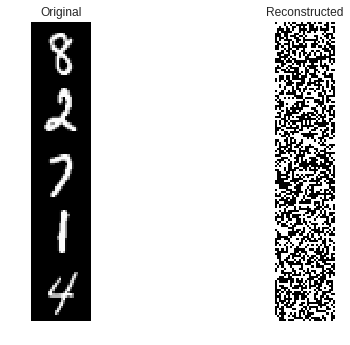

Iteration 1000:


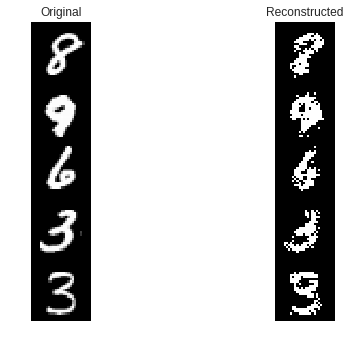

Iteration 2000:


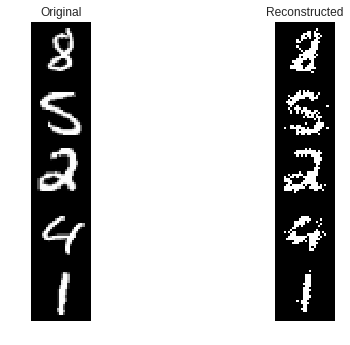

Iteration 3000:


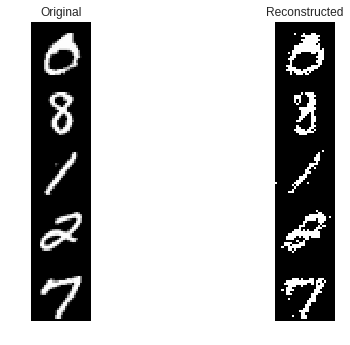

Iteration 4000:


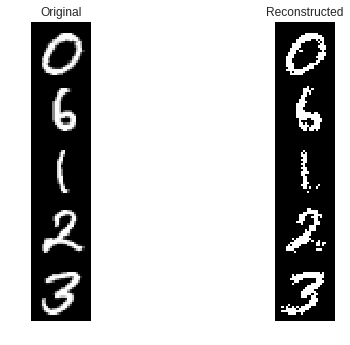

Iteration 5000:


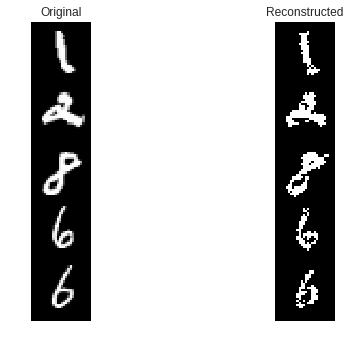

Iteration 6000:


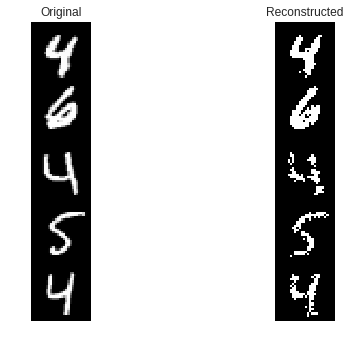

Iteration 7000:


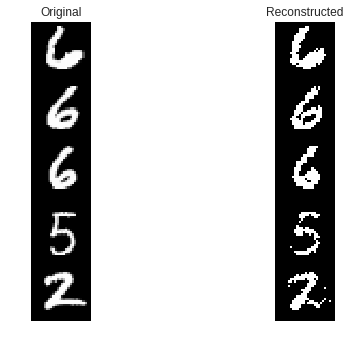

Iteration 8000:


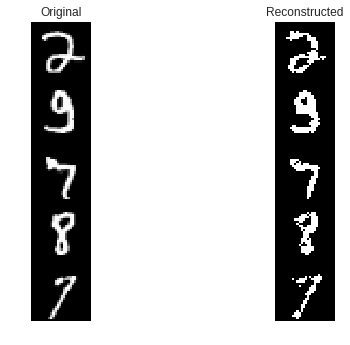

Iteration 9000:


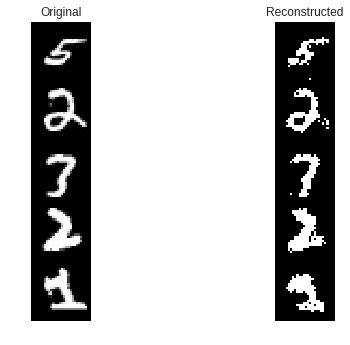

Iteration 10000:


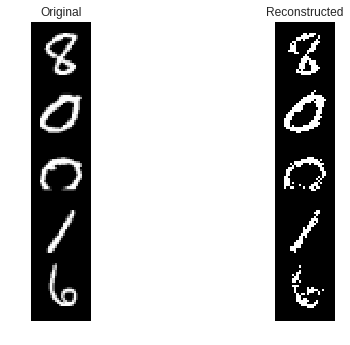

Iteration 11000:


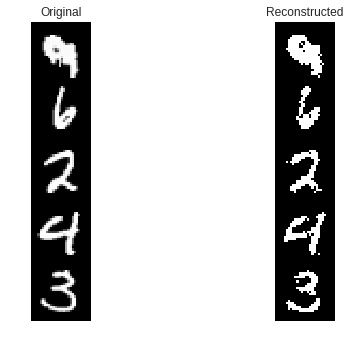

Iteration 12000:


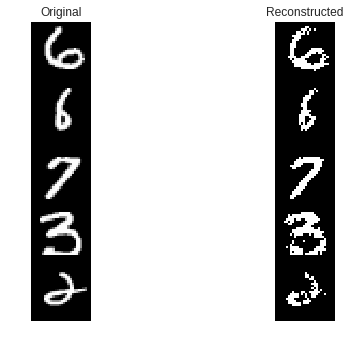

Iteration 13000:


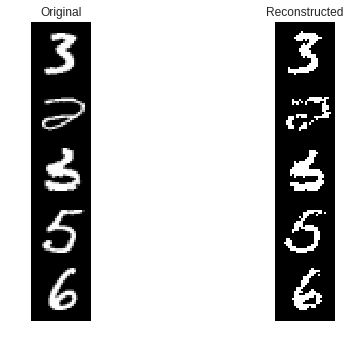

Iteration 14000:


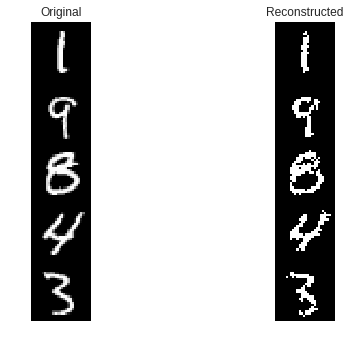

Iteration 15000:


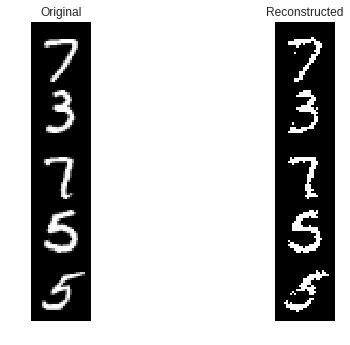

Iteration 16000:


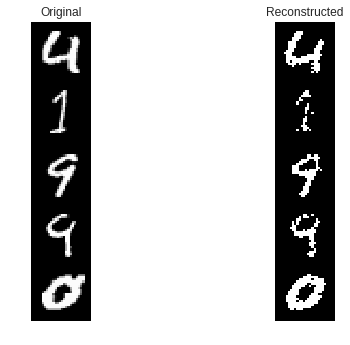

Iteration 17000:


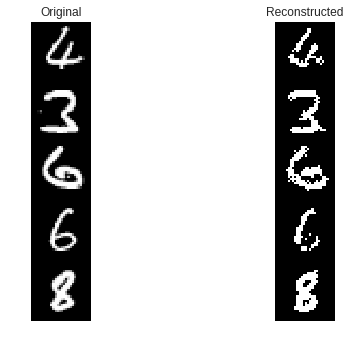

Iteration 18000:


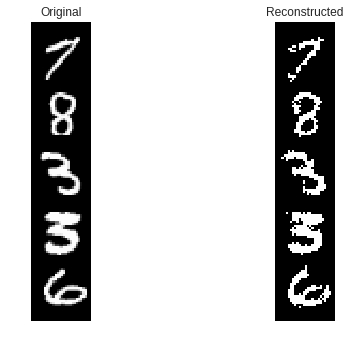

Iteration 19000:


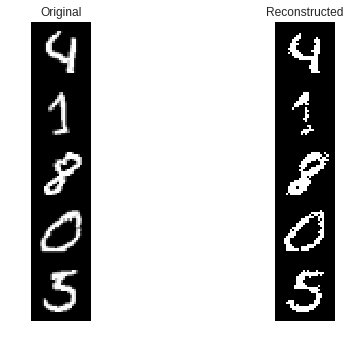

In [42]:
sess = tf.Session()  
# Initialize all variables
sess.run(tf.global_variables_initializer())

# Train VAE model
for i in range(20000):        
    # Get a training minibatch
    batch = mnist.train.next_batch(100)

    # Binarize the data
    x_binarized = (batch[0] > 0.5).astype(np.float32)

    # Train on minibatch
    sess.run(train_step_unlabeled, feed_dict={x: x_binarized}) # No labels

    # Visualize reconstructions every 1000 iterations
    if i % 1000 == 0:
        batch = mnist.validation.next_batch(5)
        x_binarized = (batch[0] > 0.5).astype(np.float32)
        reconstructions = sess.run(x_hat, feed_dict={x: x_binarized})
        print("Iteration {0}:".format(i))
        visualize_row(batch[0], reconstructions)

### (b)	Using the encoder, generate latent representations for 2 images ($z_{start}$ and $z_{end}$) matching the digit labels selected in Problem 2c.

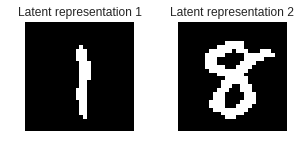

In [53]:
start_digit = 1
end_digit = 8

# Find 2 images matching digit labels chosen before
x_z_start, y_z_start = mnist.validation.next_batch(1)
while np.argmax(y_z_start) != start_digit:
    x_z_start, y_z_start = mnist.validation.next_batch(1)
x_z_start = (x_z_start > 0.5).astype(np.float32) #binarize the data

x_z_end, y_z_end = mnist.validation.next_batch(1)
while np.argmax(y_z_end) != end_digit:
    x_z_end, y_z_end = mnist.validation.next_batch(1)
x_z_end = (x_z_end > 0.5).astype(np.float32) #binarize the data

plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.imshow(np.reshape(x_z_start, [-1, 28]), cmap='gray')
plt.title('Latent representation 1')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_z_end, [-1, 28]), cmap='gray')
plt.title('Latent representation 2')
plt.axis('off')

# Generate latent representations    
z_start = sess.run(mu_logvar, feed_dict={x: x_z_start}) 
z_end = sess.run(mu_logvar, feed_dict={x: x_z_end}) 

### (c)	Generate (via decoding) and visualize images from 10 steps $z_{start} = z_1, ... , z_{10} = z_{end}$ using linear interpolation.

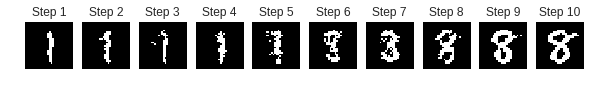

In [56]:
z_steps = []
for i in range (10):
    step = z_start + i * (z_end-z_start) / 9
    z_steps.append(step)

decoded_images = sess.run(x_hat, feed_dict={mu_logvar:np.asarray(z_steps).squeeze()})
decoded_images[0] = x_z_start
decoded_images[-1] = x_z_end

images = np.reshape(decoded_images, [-1, 28, 28])
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.clip(images[i], 0, 1), cmap='gray')
    plt.title("Step {}".format(i+1))
plt.show()

### (d) How does the quality of the VAE generated images compare to those from GAN?

Based on the results that I got from question 2(e) and question 3(c), we can see that the images generated from GAN look better and more clear than those generated from VAE. I think this is perhaps due to the fact that a lot of information was lost during the 'compression' process within VAE. A GAN is a generative model - it’s supposed to learn to generate realistic new samples of a dataset. VAEs are generative models, but autoencoders just reconstruct their inputs and can’t generate realistic new samples.

### (e) Do you observe any differences in the smoothness of the interpolation from both models?

GANs generally have smoother outputs. VAEs 'binarize' output pixels while GANs are able to produce a range [0,1] to represent output pixels.

## Problem 4: Conditioning on class labels (24 points)
**Trained GANs can generate images from simple distributions, however, we have almost no
control over the generated images. Assuming we want to generate images from specific digits,
we can modify GAN to generate images conditioned on the digit label, i.e., a conditional GAN.**

### (a) Modify the code from Problem 2 to take as input a vector 10 times longer. 
### (b) Modify the code from Problem 2 to take as input the concatenation of $\epsilon$ (random vector) and a one-hot vector encoding of the labels.


#### *Imports and Utility functions*

In [72]:
sess.close()
tf.reset_default_graph()
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

slim = tf.contrib.slim

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 25000


def visualize_row_with_condition(images, conditions, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.reshape(images, [-1,img_dim,img_dim])
    plt.figure(figsize=(10,5))
    for i in range(len(im)):
        plt.subplot(1, 10, i+1)
        plt.imshow(im[i], cmap=cmap)
        plt.axis('off')
        plt.title('spec: {}'.format(np.argmax(conditions[i])))
    plt.show()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#### *Generator and Discriminator*

In [0]:
# Generator
def generator(z_concatenated):
    hidden_layer = tf.layers.dense(z_concatenated, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X
  
# Discriminator
def discriminator(images_concatenated):
    hidden_layer = tf.layers.dense(images_concatenated, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

#### *Building the Graph*

In [0]:
# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

condition_vector = tf.placeholder(tf.float32, [None, 10]) # additional input
real_X_conditional = tf.concat([real_X, condition_vector],1) #updated real_X
z_conditional = tf.concat([z, condition_vector], 1) #updated z

# Generator updated 
with tf.variable_scope("generator") as scope:
    fake_X = generator(z_conditional)
    fake_X_conditional = tf.concat([fake_X, condition_vector], 1)

# Discriminator updated 
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X_conditional)
    scope.reuse_variables() 
    d_on_real = discriminator(real_X_conditional)

# Loss unchanged
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

# Optimizer unchanged
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

### (c)	Train the GAN.

Iter [       0] Time [0.1615] d_loss [1.9399]


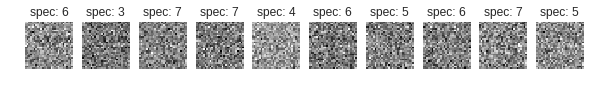

Iter [    1000] Time [5.4445] d_loss [0.0131]


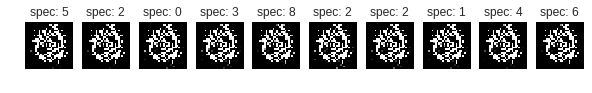

Iter [    2000] Time [11.1421] d_loss [0.0609]


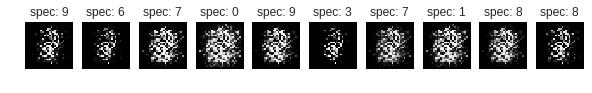

Iter [    3000] Time [16.6591] d_loss [0.0386]


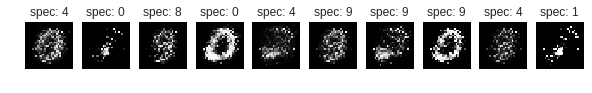

Iter [    4000] Time [22.1683] d_loss [0.1244]


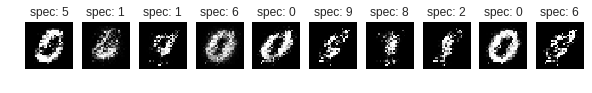

Iter [    5000] Time [27.6455] d_loss [0.0829]


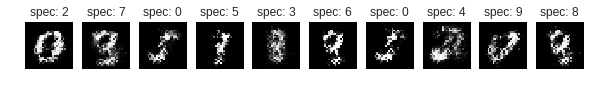

Iter [    6000] Time [33.2695] d_loss [0.3252]


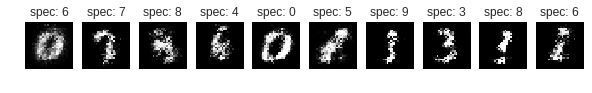

Iter [    7000] Time [38.7963] d_loss [0.2631]


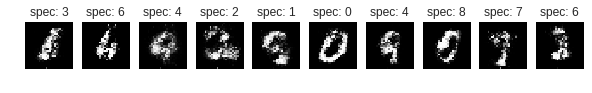

Iter [    8000] Time [44.2975] d_loss [0.4477]


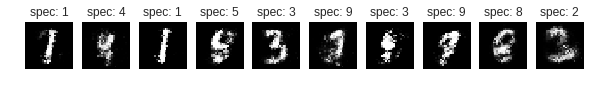

Iter [    9000] Time [49.7675] d_loss [0.6100]


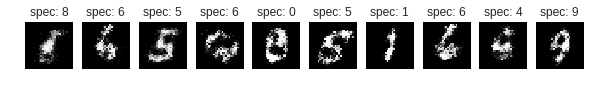

Iter [   10000] Time [55.4724] d_loss [1.0776]


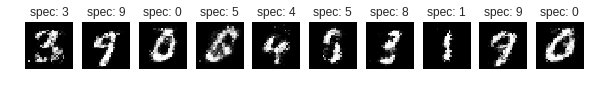

Iter [   11000] Time [60.9776] d_loss [0.7112]


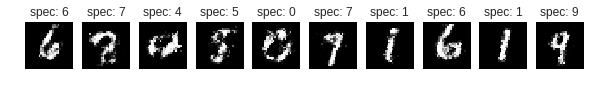

Iter [   12000] Time [66.3847] d_loss [0.8673]


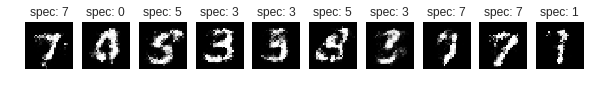

Iter [   13000] Time [71.8703] d_loss [0.8337]


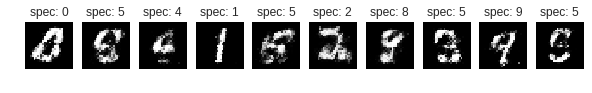

Iter [   14000] Time [77.5944] d_loss [0.5881]


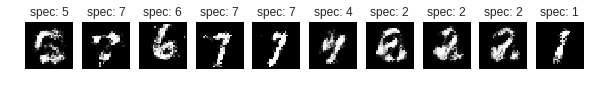

Iter [   15000] Time [83.1135] d_loss [0.5888]


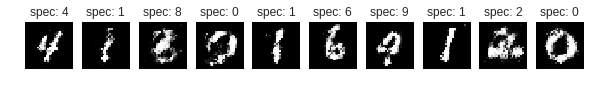

Iter [   16000] Time [88.6144] d_loss [0.7406]


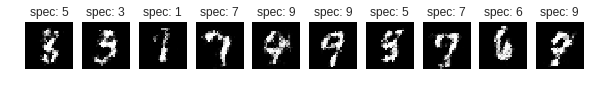

Iter [   17000] Time [94.0154] d_loss [0.8157]


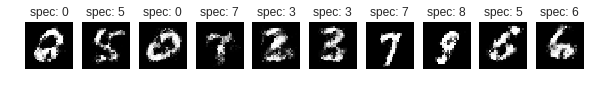

Iter [   18000] Time [99.7079] d_loss [0.7216]


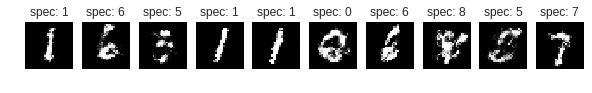

Iter [   19000] Time [105.1923] d_loss [0.7756]


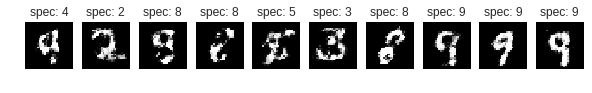

Iter [   20000] Time [110.6613] d_loss [0.8614]


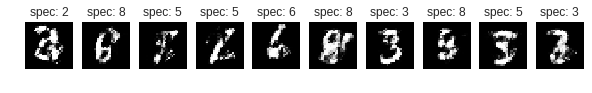

Iter [   21000] Time [116.1376] d_loss [0.7085]


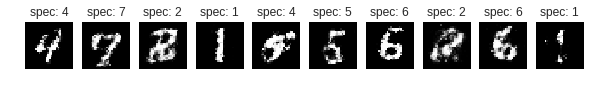

Iter [   22000] Time [121.8601] d_loss [1.0181]


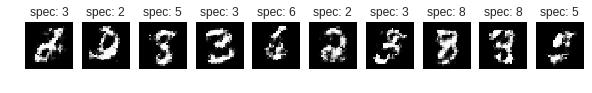

Iter [   23000] Time [127.4204] d_loss [0.8838]


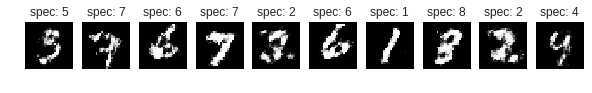

Iter [   24000] Time [133.0540] d_loss [0.7644]


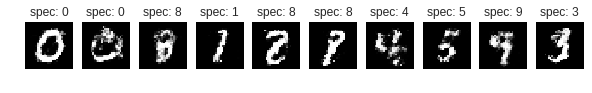

Iter [   24999] Time [138.6649] d_loss [0.9717]


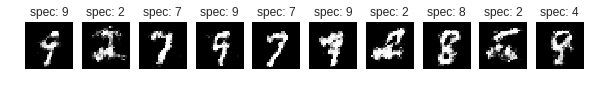

In [75]:
# Train the GAN. Updated
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])
  
def init_condition_vector():
    return np.eye(10)[np.random.choice(10, batch_size)]
  
def next_feed_dict():
    next_batch = mnist.train.next_batch(batch_size)
    return {real_X: next_batch[0],
            condition_vector: next_batch[1], #labels
            z:      make_noise()}

sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    # Training generator
    sess.run(g_step, feed_dict=next_feed_dict())
    # Training discriminator
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        cond = init_condition_vector()
        fake_data = sess.run(fake_X, feed_dict={z: make_noise(), condition_vector: cond})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row_with_condition(fake_data[:10], cond[:10])

### (d)	Generate and visualize 10 images from each digit by setting the labels accordingly as inputs to the generator and $\epsilon$ at random from its distribution.


Iter 0


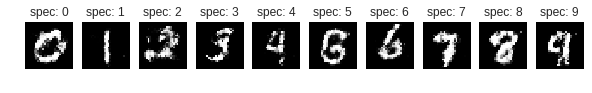

Iter 1


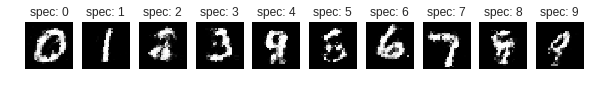

Iter 2


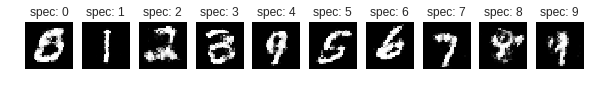

Iter 3


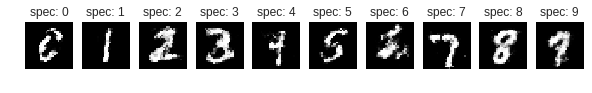

Iter 4


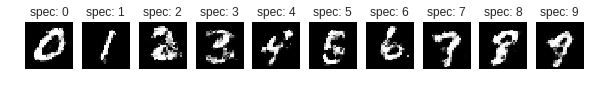

Iter 5


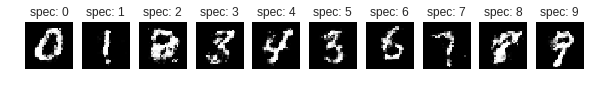

Iter 6


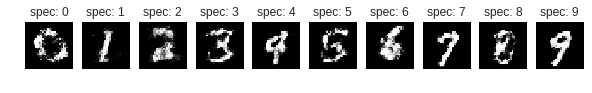

Iter 7


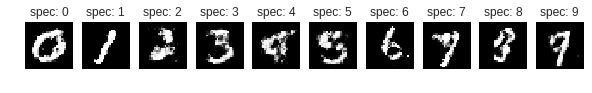

Iter 8


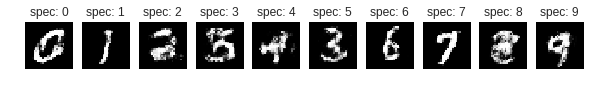

Iter 9


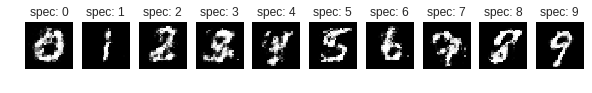

In [77]:
for i in range(10):
    print("Iter {}".format(i))
    condition = np.eye(10)
    epsilons = np.random.uniform(-1.0, 1.0, [10, z_dimension])
    fake_data = sess.run(fake_X, feed_dict={z: epsilons, condition_vector: condition})
    visualize_row_with_condition(fake_data, condition)